# **📄 Document type classification code**

> 17가지 클래스의 이미지를 분류하는 모델을 학습합니다. \
> 해당 대회의 데이터의 특징은 자동차계기판, 자동차번호판 같은 이질적인 데이터도 포함하고 있고\
> Test 데이터셋에는 다양한 Noise가 포함돼 있어 그에 대응 가능한 모델을 학습하는 것이 핵심 목표입니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Data Process
- Hyper-parameters
- Augmenation
- Data Definition
- Train Model
- Inference


## 1 Prepare Environments

In [1]:
# !pip install timm
# !pip install focal_loss_torch

## 2 Import Library & Define Functions

In [2]:
!apt-get install -y fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [3]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch import optim
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
from focal_loss.focal_loss import FocalLoss

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from timm.data.mixup import Mixup
from timm.loss import SoftTargetCrossEntropy

import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # 컴퓨터 비전 처리 라이브러리
from transformers import get_scheduler
from augraphy import *
import wandb
import random

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')


c:\Users\dudcj\Desktop\AI_Study\FastCampus\CV\competition\git\kr-document-type-classification-upstage-competition\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\dudcj\AppData\Local\Temp\ipykernel_16020\2437996278.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# 시드를 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [5]:
# 정규화된 이미지를 원래 범위로 되돌리기(EDA용)
def denormalize_image(normalized_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    denormalized_image = normalized_image * np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    denormalized_image = np.clip(denormalized_image, 0, 1)
    
    if isinstance(denormalized_image, torch.Tensor):
        denormalized_image = (denormalized_image * 255).byte()
    else:
        denormalized_image = (denormalized_image * 255).astype(np.uint8)
        
    return denormalized_image

In [6]:
# Tensor 이미지 시각화용(EDA용)
def show_img(tensor, denormalize=False):
    if denormalize:
        tensor = denormalize_image(tensor)
    ten_iamge = tensor.transpose(0, 2).transpose(0, 1)
    # ten_iamge = cv2.cvtColor(np.array(ten_iamge), cv2.COLOR_BGR2RGB)
    plt.imshow(ten_iamge)

In [7]:
# CosineAnnealingWarmRestarts 정의
# https://gaussian37.github.io/dl-pytorch-lr_scheduler/
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


### 2-1 Dataset 정의

In [8]:
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None, augraphy=None):
        self.df = df.values
        self.path = path
        self.transform = transform
        self.augraphy = augraphy

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
            
        if self.transform:
            img = self.transform(image=img)['image']
                    
        return img, target

## 3 Data Process

In [9]:
# 클래스 이름 데이터
meta_kr_df = pd.read_csv("../data/meta_kr.csv", encoding='euc-kr')

# 이미지 filename과 target
df = pd.read_csv("../data/train.csv")

# 이상데이터 처리(잘못된 라벨링, 중복 데이터)
df.loc[df['ID'] == '45f0d2dfc7e47c03.jpg', 'target'] = 7
df = df[df['ID'] != 'aec62dced7af97cd.jpg']
df = df[df['ID'] != 'c5182ab809478f12.jpg']
df.loc[df['ID'] == '8646f2c3280a4f49.jpg', 'target'] = 3
df = df[df['ID'] != '1ec14a14bbe633db.jpg']
df = df[df['ID'] != '159f76320c144a6a.jpg']

# EDA를 위해 meta 데이터 병합
df = df.merge(meta_kr_df, how='left', on='target')
df['path'] = "../data/train/" + df['ID']

df_test = pd.read_csv("../data/sample_submission.csv")
df_test['path'] = "../data/test/" + df_test['ID']

### 3-1 Train/Valid 분활

In [10]:
# Stratified K-Fold 를 이용해서 Train, Valid 분활
temp_X = df.drop(columns=['target'])
temp_y = df['target']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(temp_X, temp_y):
    new_df = df.iloc[train_index]
    val_df = df.iloc[test_index]
    break

### 3-2 Class imbalance 중복데이터로 처리

In [11]:
# 불균형 해결하기
oversample_cols = ['resume', 'statement_of_opinion', 'application_for_payment_of_pregnancy_medical_expenses']

def oversampling(df, cols):
    class_num = df['class_name'].value_counts().max()
    temp = df[df['class_name'] == 'resume']
    samples = temp.sample(class_num - temp.shape[0])
    df = pd.concat([df, samples], axis=0)

    temp = df[df['class_name'] == 'statement_of_opinion']
    df = pd.concat([df, temp], axis=0)

    temp = df[df['class_name'] == 'application_for_payment_of_pregnancy_medical_expenses']
    df = pd.concat([df, temp], axis=0)
    
    return df

In [12]:
new_df = oversampling(new_df, oversample_cols)
val_df = oversampling(val_df, oversample_cols)

## 4 Hyper-parameters

In [13]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'timm/caformer_s18.sail_in22k_ft_in1k_384' 

# training config
img_size = 384
LR = 1e-4
EPOCHS = 60
BATCH_SIZE = 32
PATIENCE = 25
num_workers = 0

model_path = '../model/caformer/'
FILENAME = 'caformer_s18_sail_in22k_ft_in1k_384.pth'
PRO_NAME = "kyc-DC-caformer_s18_386"


## 5 Augmenation

### 5-1 augraphys

In [14]:
# 글자의 번짐 혹은 뭉개짐을 유도
ink_phase = [
    InkBleed(intensity_range=(0.3, 0.6),
             kernel_size=random.choice([(5, 5), (3, 3)]),
             severity=(0.2, 0.6),
             p=0.5,),
    
    Hollow(hollow_median_kernel_value_range = (3, 10),
                hollow_min_width_range=(1, 3),
                hollow_max_width_range=(10, 15),
                hollow_min_height_range=(1, 3),
                hollow_max_height_range=(10, 15),
                hollow_min_area_range=(1, 3),
                hollow_max_area_range=(20, 50),
                hollow_dilation_kernel_size_range = (1, 2),
                p=1.0)
]

# 노이즈와 밝기
paper_phase = [
    OneOf([
        NoiseTexturize(sigma_range=(5, 20),
                        turbulence_range=(3, 10),
                        texture_width_range=(50, 500),
                        texture_height_range=(50, 500),
                        p=0.7),
        
        VoronoiTessellation(mult_range = (50, 80),
                            #seed = 19829813472,
                            num_cells_range = (500,1000),
                            noise_type = "random",
                            background_value = (170, 225),),
    ], p=1.0),
    
    BrightnessTexturize(texturize_range=(0.9, 0.99),
                        deviation=0.03,
                        p=0.4),
]

# 그림자
post_phase = [
    ShadowCast(shadow_side = "bottom",
                shadow_vertices_range = (2, 3),
                shadow_width_range=(0.5, 0.8),
                shadow_height_range=(0.5, 0.8),
                shadow_color = (0, 0, 0),
                shadow_opacity_range=(0.5,0.6),
                shadow_iterations_range = (1,2),
                shadow_blur_kernel_range = (101, 301),
                p=0.2),
]

pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)

In [15]:
# # EDA용 시각화 코드
# idx = random.randint(0, len(df))
# # idx = 864
# path = df.iloc[idx]['path']

# image = cv2.imread(path)
# aug_image = pipeline(image)

# plt.figure(figsize=(10,10))
# plt.imshow(aug_image)
# plt.title(idx)

In [16]:
# # 데이터 증강 코드
# # augraphys 라이브러리가 Albumentations 에 비해서 많이 느려서 빠른 학습을 위해 증강한 데이터를 저장해서 사용

# # Train 데이터를 200배 증강하고 각각 다른 폴더에 저장해 매 애폭마다 다르게 augraphys가 적용된 데이터를 가져와서 사용할 수 있게 하였습니다.(200 에폭분량)
# aug_count = 200
# for i in range(aug_count):
#     folder_path = f"../data/aug/train{str(i)}"
#     if not os.path.exists(folder_path):
#         os.mkdir(folder_path)
    
#     for idx in tqdm(range(len(df)), desc="Processing Images"):
#         id = df.iloc[idx]['ID']
#         path = df.iloc[idx]['path']
        
#         image = cv2.imread(path)
        
#         # 랜덤으로 하나를 골라서 적용
#         image = pipeline(image)
        
#         save_path = os.path.join(folder_path, id)
#         cv2.imwrite(save_path, image)

### 5-2 Albumentations

In [17]:
# 원본 데이터셋에 적용될 Albumentations
trn_transform = A.Compose([
    A.OneOf([
        # 비율을 유지하며 이미지 전체를 학습하기 위함
        A.Compose([
            A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_CUBIC), # 가장 긴변을 img_size에 맞춤
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]), # 패딩
            A.OneOf([ # 회전 및 스케일링
                A.Rotate(limit=360, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=360, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            ], p=0.8),
            A.CoarseDropout (max_holes=6, max_height=96, max_width=96, min_holes=2, min_height=24, min_width=24, fill_value=0, p=0.2), # cutout
        ], p=0.6),
        
        # 문서의 제목을 학습하기 위함
        A.Compose([
            A.LongestMaxSize(max_size=640, interpolation=cv2.INTER_CUBIC),
            A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            
            # Shift를 줘서 다양한 형태의 제목 이미지를 학습하기를 의도
            A.ShiftScaleRotate(shift_limit_x=0.2, shift_limit_y=(0.0, 0.1), scale_limit=0.2, rotate_limit=0, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.Crop (x_min=128, y_min=0, x_max=128+384, y_max=384, p=1.0), # 윗쪽 중앙 크롭(대부분의 문서의 제목이 있는 위치)
            A.OneOf([
                A.Rotate(limit=360, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.3),
            ], p=0.8),
        ], p=0.4)
    ], p=1.0),
    
    A.OneOf([
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.6),
        A.ChannelShuffle(p=0.4),
    ], p=0.2),
    
    A.OneOf([A.MotionBlur(p=0.3), A.MedianBlur(blur_limit=3, p=0.3), A.Blur(blur_limit=3, p=0.4),], p=0.2), # 블러
    A.GaussNoise(var_limit=(30.0, 250.0), mean=0, per_channel=True, p=0.2), # 노이즈
    A.RandomBrightnessContrast (brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), brightness_by_max=True, p=0.2), # 밝기
    A.OneOf([A.OpticalDistortion(p=0.5), A.PiecewiseAffine(scale=(0.01, 0.03), p=0.5)], p=1.0), # 구겨진 느낌
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
    ToTensorV2(),
])

# augraphys가 적용된 데이터셋에 적용할 Albumentations
# GaussNoise외에는 trn_transform과 동일
trn_transform02 = A.Compose([ 
    A.OneOf([
        A.Compose([
            A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_CUBIC),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.OneOf([
                A.Rotate(limit=360, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=360, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            ], p=0.8),
            A.CoarseDropout (max_holes=6, max_height=96, max_width=96, min_holes=2, min_height=24, min_width=24, fill_value=0, p=0.2),
        ], p=0.6),
        
        A.Compose([
            A.LongestMaxSize(max_size=640, interpolation=cv2.INTER_CUBIC),
            A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.ShiftScaleRotate(shift_limit_x=0.2, shift_limit_y=(0.0, 0.1), scale_limit=0.2, rotate_limit=0, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.Crop (x_min=128, y_min=0, x_max=128+384, y_max=384, p=1.0),
            A.OneOf([
                A.Rotate(limit=360, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.3),
            ], p=0.8),
        ], p=0.4)
    ], p=1.0),
    
    A.OneOf([
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.6),
        A.ChannelShuffle(p=0.4),
    ], p=0.5),
    
    A.OneOf([A.MotionBlur(p=0.3), A.MedianBlur(blur_limit=3, p=0.3), A.Blur(blur_limit=3, p=0.4),], p=0.2),
    A.RandomBrightnessContrast (brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), brightness_by_max=True, p=0.2),
    A.OneOf([A.OpticalDistortion(p=0.5), A.PiecewiseAffine(scale=(0.01, 0.03), p=0.5)], p=0.15),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255),
    ToTensorV2(),
])

# test셋에 적용될 Albumentations(TTA)
tst_transform = A.Compose([
    A.OneOf([
        # 비율을 유지하며 이미지 전체를 보기 위함
        A.Compose([
            A.LongestMaxSize(max_size=img_size, interpolation=cv2.INTER_CUBIC),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.OneOf([
                A.Rotate(limit=360, p=0.7, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.3),
            ], p=0.8),
        ], p=0.4),
        
        # 조금더 좁은 범위의 이미지를 RandomCrop
        A.Compose([
            A.PadIfNeeded(min_height=560, min_width=560, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.RandomCrop(img_size, img_size),
            A.OneOf([
                A.Rotate(limit=360, p=0.7, interpolation=cv2.INTER_CUBIC, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.3),
            ], p=0.8),
        ], p=0.2),
        
        # 문서의 제목을 보기 위함
        A.Compose([
            A.LongestMaxSize(max_size=640, interpolation=cv2.INTER_CUBIC),
            A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.ShiftScaleRotate(shift_limit_x=0.2, shift_limit_y=(0.0, 0.1), scale_limit=0.2, rotate_limit=0, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
            A.Crop (x_min=128, y_min=0, x_max=128+384, y_max=384, p=1.0),
            A.OneOf([
                A.Rotate(limit=360, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255]),
                A.RandomRotate90(p=0.3),
            ], p=0.8),
        ], p=0.4),
    ], p=1.0),
    
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

### 5-3 Mixup

In [18]:
mixup_fn = Mixup(
mixup_alpha=0.3, cutmix_alpha=0.0, prob=0.8, switch_prob=0.5, mode='elem',
label_smoothing=0.1, num_classes=17
)

## 6 Data Definition

### 6-1 Dataset 정의

In [19]:
# 원본 train + Albumentations
trn_dataset = ImageDataset(
    new_df[['ID', 'target']],
    "../data/train/",
    transform=trn_transform,
)

# augraphys train + Albumentations
# 200 에폭 분량의 데이터셋 정의
aug_trn_dataset_list = []
for i in range(0, 200):
    folder_path = f"../data/aug/train{str(i)}/"
    aug_trn_dataset = ImageDataset(new_df[['ID', 'target']], folder_path, transform=trn_transform02)
    aug_trn_dataset_list.append(aug_trn_dataset)
    

# 원본 valid + Albumentations
val_dataset = ImageDataset(
    val_df[['ID', 'target']],
    "../data/train/",
    transform=trn_transform
)

# augraphys valid + Albumentations
# 200 에폭 분량의 데이터셋 정의
aug_val_dataset_list = []
for i in range(0, 200):
    folder_path = f"../data/aug/train{str(i)}/"
    aug_val_dataset = ImageDataset(val_df[['ID', 'target']], folder_path, transform=trn_transform02)
    aug_val_dataset_list.append(aug_val_dataset)


# RotNet으로 회전시킨 test셋을 불러와서 Dataset 구성
tst_rot_dataset = ImageDataset(
    df_test[['ID', 'target']],
    "../data/test_rot_cafomer01/",
    transform=tst_transform
)

print(len(trn_dataset), len(val_dataset), len(tst_rot_dataset))
print(len(aug_trn_dataset_list), len(aug_val_dataset_list))

1348 339 3140
200 200


### 6-2 Dataset EDA
- 데이터에 augmenation이 잘 적용됐는지 확인용

In [ ]:
idx = random.randint(0, len(tst_rot_dataset))
# idx = 2107
plt.figure(figsize=(10, 10))
plt.title(idx)
show_img(tst_rot_dataset[idx][0], True)

In [ ]:
idx = random.randint(0, len(trn_dataset))
idx = 631
plt.figure(figsize=(10, 10))
plt.title(idx)
show_img(trn_dataset[idx][0], True)

In [22]:
# idx = random.randint(0, len(aug_val_dataset_list[0]))
# # idx = 2

# plt.figure(figsize=(10, 10))
# plt.title(idx)
# show_img(aug_val_dataset_list[0][idx][0], True)

### 6-3 DataLoader 정의

In [23]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_rot_loader = DataLoader(
    tst_rot_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(len(trn_loader), len(val_loader), len(tst_rot_loader))

43 11 99


## 7 Train Model

In [24]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)

# loss_fn = nn.CrossEntropyLoss()
mixup_loss_fn = SoftTargetCrossEntropy()
loss_fn = FocalLoss(gamma=1.5)

In [25]:
# 학습코드
def training(model, dataloader, optimizer, loss_fn, scheduler, device, epoch, num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    train_loss = 0.0
    preds_list = []
    targets_list = []
    m = torch.nn.Softmax(dim=-1)

    tbar = tqdm(dataloader)
    for idx, (image, targets) in enumerate(tbar):
        image = image.to(device)
        targets = targets.to(device)
        
        # 순전파
        model.zero_grad(set_to_none=True)
        if (idx + 1) % 10 == 0: # Mixup
            image, mix_targets = mixup_fn(image, targets)
            preds = model(image)
            loss = mixup_loss_fn(preds, mix_targets)
        else:
            preds = model(image)
            # loss = loss_fn(preds, targets)
            loss = loss_fn(m(preds), targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # 손실과 정확도 계산
        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())
        tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

    # 에폭별 학습 결과 출력
    train_loss = train_loss / len(dataloader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')
    
    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return model, ret

# 평가코드
def evaluation(model, dataloader, loss_fn, device, epoch, num_epochs):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    preds_list = []
    targets_list = []
    m = torch.nn.Softmax(dim=-1)

    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for idx, (image, targets) in enumerate(tbar):
            image = image.to(device)
            targets = targets.to(device)

            # 순전파
            model.zero_grad(set_to_none=True)
            if (idx + 1) % 8 == 0:
                image, mix_targets = mixup_fn(image, targets)
                preds = model(image)
                loss = mixup_loss_fn(preds, mix_targets)
            else:
                preds = model(image)
                loss = loss_fn(m(preds), targets)

            # 손실과 정확도 계산
            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())
            tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")
            
    # 에폭별 학습 결과 출력
    valid_loss = valid_loss / len(dataloader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average='macro')
    
    ret = {
        "valid_loss": valid_loss,
        "valid_acc": valid_acc,
        "valid_f1": valid_f1,
    }

    return model, ret

# 학습 루프
def training_loop(model, train_dataloader, valid_dataloader, trn_dataset, val_dataset, train_dataset_list, val_dataset_list, loss_fn, optimizer, scheduler, device, num_epochs, patience, filename, project_name):
    best_valid_loss = float('inf')  
    early_stop_counter = 0  
    valid_max_acc = -1
    valid_max_f1 = -1
    
    # wandb
    notes = f"Optimizer: {optimizer.__class__.__name__}, focal_gamma: {loss_fn.gamma}, Image_Size: {img_size},"
    run = wandb.init(project = project_name, tags=[optimizer.__class__.__name__], notes=notes)
    
    for epoch in range(num_epochs):
        # 매 에폭마다 다르게 Augraphys가 적용된 데이터 불러오기
        data_idx = epoch % 200
        T_dataset = ConcatDataset([trn_dataset, train_dataset_list[data_idx]])
        V_dataset = ConcatDataset([val_dataset, val_dataset_list[data_idx]])
        
        train_dataloader = DataLoader(T_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=False)
        valid_dataloader = DataLoader(V_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)
        print(f"dataset{data_idx}")
        
        model, train_ret = training(model, train_dataloader, optimizer, loss_fn, scheduler, device, epoch, num_epochs)
        model, valid_ret = evaluation(model, valid_dataloader, loss_fn, device, epoch, num_epochs)
        
        # 모니터링 변수
        monitoring_value = {'train_loss': train_ret['train_loss'], 'train_accuracy': train_ret['train_acc'], 'train_f1': train_ret['train_f1'], 
                            'valid_loss': valid_ret['valid_loss'], 'valid_accuracy': valid_ret['valid_acc'], 'valid_f1': valid_ret['valid_f1'], 
                            'best_valid_loss': best_valid_loss, 'valid_max_acc': valid_max_acc, 'valid_max_f1': valid_max_f1,
                            'init_lr': optimizer.param_groups[0]['initial_lr'], 'lr': optimizer.param_groups[0]['lr'],
                            'weight decay': optimizer.param_groups[0]['weight_decay'],}
        
        run.log(monitoring_value, step=epoch)
        
        if valid_ret['valid_acc'] > valid_max_acc:
            valid_max_acc = valid_ret['valid_acc']
            
        if valid_ret['valid_f1'] > valid_max_f1:
            name, ext = os.path.splitext(filename)
            torch.save(model.state_dict(), model_path+name+'_f1'+ext)
            valid_max_f1 = valid_ret['valid_f1']
        
        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_ret['valid_loss'] < best_valid_loss:
            best_valid_loss = valid_ret['valid_loss']
            name, ext = os.path.splitext(filename)
            torch.save(model.state_dict(), model_path+name+'_loss'+ext)
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], T_Train Loss: {train_ret['train_loss']:.4f}, Train Accuracy: {train_ret['train_acc']:.4f}, Train F1: {train_ret['train_f1']:.4f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], T_Valid Loss: {valid_ret['valid_loss']:.4f}, Valid Accuracy: {valid_ret['valid_acc']:.4f}, Valid F1: {valid_ret['valid_f1']:.4f}")

        # early_stopping
        if early_stop_counter >= patience:
            print("Early stopping")
            break
            
    run.finish()
    return model, valid_max_acc, valid_max_f1

In [150]:
# 모델 전체 fine tuning
model.to(device)
num_epochs = EPOCHS
lr = LR
patience = PATIENCE
filename = FILENAME
project_name = PRO_NAME

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)

num_epoch_steps = len(trn_loader) * 2

# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=num_epoch_steps*20, T_mult=2, eta_max=lr,  T_up=num_epoch_steps*1, gamma=0.5)
scheduler = get_scheduler(
    name='cosine', optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps= num_epoch_steps * num_epochs
)

model, valid_max_acc, valid_max_f1 = training_loop(model, trn_loader, val_loader, trn_dataset, val_dataset, aug_trn_dataset_list, aug_val_dataset_list, loss_fn, optimizer, scheduler, device, num_epochs, patience, filename, project_name)
print(f'Valid max accuracy : {valid_max_acc:5f}, Valid max f1 : {valid_max_f1:5f}')

dataset0


Epoch [1/60], Valid Loss: 0.4617: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch [1/60], T_Train Loss: 0.9080, Train Accuracy: 0.6139, Train F1: 0.6159
Epoch [1/60], T_Valid Loss: 0.5187, Valid Accuracy: 0.7522, Valid F1: 0.7456
dataset1


Epoch [2/60], Valid Loss: 1.0050: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


Epoch [2/60], T_Train Loss: 0.4215, Train Accuracy: 0.7878, Train F1: 0.7862
Epoch [2/60], T_Valid Loss: 0.4331, Valid Accuracy: 0.7965, Valid F1: 0.7968
dataset2


Epoch [3/60], Valid Loss: 0.1466: 100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Epoch [3/60], T_Train Loss: 0.3060, Train Accuracy: 0.8457, Train F1: 0.8452
Epoch [3/60], T_Valid Loss: 0.3321, Valid Accuracy: 0.8304, Valid F1: 0.8223
dataset3


Epoch [4/60], Valid Loss: 0.1632: 100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Epoch [4/60], T_Train Loss: 0.2782, Train Accuracy: 0.8527, Train F1: 0.8522
Epoch [4/60], T_Valid Loss: 0.2923, Valid Accuracy: 0.8628, Valid F1: 0.8600
dataset4


Epoch [5/60], Valid Loss: 0.0446: 100%|██████████| 22/22 [00:25<00:00,  1.16s/it]


Epoch [5/60], T_Train Loss: 0.2461, Train Accuracy: 0.8746, Train F1: 0.8741
Epoch [5/60], T_Valid Loss: 0.2662, Valid Accuracy: 0.8496, Valid F1: 0.8473
dataset5


Epoch [6/60], Valid Loss: 1.0214: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch [6/60], T_Train Loss: 0.2192, Train Accuracy: 0.8861, Train F1: 0.8855
Epoch [6/60], T_Valid Loss: 0.3138, Valid Accuracy: 0.8584, Valid F1: 0.8588
dataset6


Epoch [7/60], Valid Loss: 0.0018: 100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Epoch [7/60], T_Train Loss: 0.2199, Train Accuracy: 0.8861, Train F1: 0.8859
Epoch [7/60], T_Valid Loss: 0.2377, Valid Accuracy: 0.8746, Valid F1: 0.8742
dataset7


Epoch [8/60], Valid Loss: 0.0424: 100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Epoch [8/60], T_Train Loss: 0.2224, Train Accuracy: 0.8798, Train F1: 0.8803
Epoch [8/60], T_Valid Loss: 0.2753, Valid Accuracy: 0.8687, Valid F1: 0.8693
dataset8


Epoch [9/60], Valid Loss: 0.2870: 100%|██████████| 22/22 [00:24<00:00,  1.14s/it]


Epoch [9/60], T_Train Loss: 0.2039, Train Accuracy: 0.8872, Train F1: 0.8873
Epoch [9/60], T_Valid Loss: 0.2925, Valid Accuracy: 0.8540, Valid F1: 0.8536
dataset9


Epoch [10/60], Valid Loss: 0.0047: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch [10/60], T_Train Loss: 0.2028, Train Accuracy: 0.8973, Train F1: 0.8967
Epoch [10/60], T_Valid Loss: 0.2375, Valid Accuracy: 0.8835, Valid F1: 0.8819
dataset10


Epoch [11/60], Valid Loss: 0.3384: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [11/60], T_Train Loss: 0.1626, Train Accuracy: 0.9154, Train F1: 0.9155
Epoch [11/60], T_Valid Loss: 0.2765, Valid Accuracy: 0.8555, Valid F1: 0.8529
dataset11


Epoch [12/60], Valid Loss: 0.0243: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch [12/60], T_Train Loss: 0.1698, Train Accuracy: 0.9106, Train F1: 0.9108
Epoch [12/60], T_Valid Loss: 0.2490, Valid Accuracy: 0.8776, Valid F1: 0.8743
dataset12


Epoch [13/60], Valid Loss: 0.0103: 100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


Epoch [13/60], T_Train Loss: 0.1903, Train Accuracy: 0.9013, Train F1: 0.9010
Epoch [13/60], T_Valid Loss: 0.2726, Valid Accuracy: 0.8761, Valid F1: 0.8700
dataset13


Epoch [14/60], Valid Loss: 0.0008: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch [14/60], T_Train Loss: 0.1708, Train Accuracy: 0.9132, Train F1: 0.9132
Epoch [14/60], T_Valid Loss: 0.2238, Valid Accuracy: 0.8850, Valid F1: 0.8836
dataset14


Epoch [15/60], Valid Loss: 0.0002: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch [15/60], T_Train Loss: 0.1550, Train Accuracy: 0.9158, Train F1: 0.9156
Epoch [15/60], T_Valid Loss: 0.2085, Valid Accuracy: 0.9115, Valid F1: 0.9101
dataset15


Epoch [16/60], Valid Loss: 0.0068: 100%|██████████| 22/22 [00:23<00:00,  1.07s/it]


Epoch [16/60], T_Train Loss: 0.1644, Train Accuracy: 0.9180, Train F1: 0.9178
Epoch [16/60], T_Valid Loss: 0.1760, Valid Accuracy: 0.9056, Valid F1: 0.9045
dataset16


Epoch [17/60], Valid Loss: 0.0444: 100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


Epoch [17/60], T_Train Loss: 0.1499, Train Accuracy: 0.9258, Train F1: 0.9253
Epoch [17/60], T_Valid Loss: 0.2763, Valid Accuracy: 0.8717, Valid F1: 0.8688
dataset17


Epoch [18/60], Valid Loss: 0.0029: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch [18/60], T_Train Loss: 0.1450, Train Accuracy: 0.9225, Train F1: 0.9222
Epoch [18/60], T_Valid Loss: 0.2279, Valid Accuracy: 0.8850, Valid F1: 0.8855
dataset18


Epoch [19/60], Valid Loss: 0.0357: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


Epoch [19/60], T_Train Loss: 0.1560, Train Accuracy: 0.9247, Train F1: 0.9246
Epoch [19/60], T_Valid Loss: 0.2034, Valid Accuracy: 0.8938, Valid F1: 0.8926
dataset19


Epoch [20/60], Valid Loss: 0.0091: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [20/60], T_Train Loss: 0.1492, Train Accuracy: 0.9299, Train F1: 0.9297
Epoch [20/60], T_Valid Loss: 0.2062, Valid Accuracy: 0.8909, Valid F1: 0.8907
dataset20


Epoch [21/60], Valid Loss: 0.0224: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch [21/60], T_Train Loss: 0.1454, Train Accuracy: 0.9366, Train F1: 0.9364
Epoch [21/60], T_Valid Loss: 0.2171, Valid Accuracy: 0.8894, Valid F1: 0.8873
dataset21


Epoch [22/60], Valid Loss: 0.0068: 100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Epoch [22/60], T_Train Loss: 0.1544, Train Accuracy: 0.9273, Train F1: 0.9272
Epoch [22/60], T_Valid Loss: 0.2713, Valid Accuracy: 0.8835, Valid F1: 0.8845
dataset22


Epoch [23/60], Valid Loss: 0.0066: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Epoch [23/60], T_Train Loss: 0.1483, Train Accuracy: 0.9280, Train F1: 0.9278
Epoch [23/60], T_Valid Loss: 0.2149, Valid Accuracy: 0.8938, Valid F1: 0.8928
dataset23


Epoch [24/60], Valid Loss: 0.0913: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch [24/60], T_Train Loss: 0.1353, Train Accuracy: 0.9347, Train F1: 0.9344
Epoch [24/60], T_Valid Loss: 0.2364, Valid Accuracy: 0.8805, Valid F1: 0.8797
dataset24


Epoch [25/60], Valid Loss: 0.0023: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [25/60], T_Train Loss: 0.1363, Train Accuracy: 0.9355, Train F1: 0.9353
Epoch [25/60], T_Valid Loss: 0.2217, Valid Accuracy: 0.9041, Valid F1: 0.9040
dataset25


Epoch [26/60], Valid Loss: 0.4920: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch [26/60], T_Train Loss: 0.1273, Train Accuracy: 0.9403, Train F1: 0.9405
Epoch [26/60], T_Valid Loss: 0.2465, Valid Accuracy: 0.8953, Valid F1: 0.8946
dataset26


Epoch [27/60], Valid Loss: 0.0902: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch [27/60], T_Train Loss: 0.1177, Train Accuracy: 0.9403, Train F1: 0.9401
Epoch [27/60], T_Valid Loss: 0.2231, Valid Accuracy: 0.8864, Valid F1: 0.8843
dataset27


Epoch [28/60], Valid Loss: 0.0004: 100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


Epoch [28/60], T_Train Loss: 0.1190, Train Accuracy: 0.9399, Train F1: 0.9398
Epoch [28/60], T_Valid Loss: 0.2373, Valid Accuracy: 0.8894, Valid F1: 0.8869
dataset28


Epoch [29/60], Valid Loss: 0.0096: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [29/60], T_Train Loss: 0.1118, Train Accuracy: 0.9473, Train F1: 0.9472
Epoch [29/60], T_Valid Loss: 0.1916, Valid Accuracy: 0.9189, Valid F1: 0.9180
dataset29


Epoch [30/60], Valid Loss: 0.0133: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch [30/60], T_Train Loss: 0.1252, Train Accuracy: 0.9462, Train F1: 0.9462
Epoch [30/60], T_Valid Loss: 0.2137, Valid Accuracy: 0.9027, Valid F1: 0.9016
dataset30


Epoch [31/60], Valid Loss: 0.0022: 100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Epoch [31/60], T_Train Loss: 0.1067, Train Accuracy: 0.9458, Train F1: 0.9458
Epoch [31/60], T_Valid Loss: 0.2279, Valid Accuracy: 0.8982, Valid F1: 0.8985
dataset31


Epoch [32/60], Valid Loss: 0.0414: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Epoch [32/60], T_Train Loss: 0.1124, Train Accuracy: 0.9447, Train F1: 0.9447
Epoch [32/60], T_Valid Loss: 0.1970, Valid Accuracy: 0.9204, Valid F1: 0.9200
dataset32


Epoch [33/60], Valid Loss: 0.0030: 100%|██████████| 22/22 [00:22<00:00,  1.03s/it]


Epoch [33/60], T_Train Loss: 0.1081, Train Accuracy: 0.9462, Train F1: 0.9460
Epoch [33/60], T_Valid Loss: 0.1853, Valid Accuracy: 0.9189, Valid F1: 0.9179
dataset33


Epoch [34/60], Valid Loss: 0.0007: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [34/60], T_Train Loss: 0.1071, Train Accuracy: 0.9503, Train F1: 0.9503
Epoch [34/60], T_Valid Loss: 0.2128, Valid Accuracy: 0.9159, Valid F1: 0.9137
dataset34


Epoch [35/60], Valid Loss: 0.0006: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Epoch [35/60], T_Train Loss: 0.1081, Train Accuracy: 0.9488, Train F1: 0.9486
Epoch [35/60], T_Valid Loss: 0.1926, Valid Accuracy: 0.9086, Valid F1: 0.9080
dataset35


Epoch [36/60], Valid Loss: 0.5655: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch [36/60], T_Train Loss: 0.1042, Train Accuracy: 0.9503, Train F1: 0.9502
Epoch [36/60], T_Valid Loss: 0.2172, Valid Accuracy: 0.9145, Valid F1: 0.9145
dataset36


Epoch [37/60], Valid Loss: 0.0005: 100%|██████████| 22/22 [00:26<00:00,  1.18s/it]


Epoch [37/60], T_Train Loss: 0.1011, Train Accuracy: 0.9492, Train F1: 0.9493
Epoch [37/60], T_Valid Loss: 0.2093, Valid Accuracy: 0.9086, Valid F1: 0.9061
dataset37


Epoch [38/60], Valid Loss: 0.0002: 100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


Epoch [38/60], T_Train Loss: 0.0989, Train Accuracy: 0.9540, Train F1: 0.9538
Epoch [38/60], T_Valid Loss: 0.2131, Valid Accuracy: 0.9056, Valid F1: 0.9056
dataset38


Epoch [39/60], Valid Loss: 0.0055: 100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Epoch [39/60], T_Train Loss: 0.1026, Train Accuracy: 0.9581, Train F1: 0.9581
Epoch [39/60], T_Valid Loss: 0.1788, Valid Accuracy: 0.9218, Valid F1: 0.9223
dataset39


Epoch [40/60], Valid Loss: 0.0036: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s]


Epoch [40/60], T_Train Loss: 0.0978, Train Accuracy: 0.9618, Train F1: 0.9619
Epoch [40/60], T_Valid Loss: 0.1837, Valid Accuracy: 0.9174, Valid F1: 0.9161
dataset40


Epoch [41/60], Valid Loss: 0.0204: 100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Epoch [41/60], T_Train Loss: 0.0978, Train Accuracy: 0.9536, Train F1: 0.9537
Epoch [41/60], T_Valid Loss: 0.2122, Valid Accuracy: 0.9100, Valid F1: 0.9089
Early stopping


best_valid_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
train_accuracy,▁▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
train_f1,▁▄▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▃▄▆▅▅▆▆▅▆▅▆▆▆█▇▆▆▇▇▇▆▇▆▇▇▇▇█▇▇███▇█▇▇██
valid_f1,▁▃▄▆▅▅▆▆▅▆▅▆▆▆█▇▆▇▇▇▇▇▇▆▇▇▆▇█▇▇███▇█▇▇█▇
valid_loss,█▆▄▃▃▄▂▃▃▂▃▂▃▂▂▁▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▂▂▂▁▂
valid_max_acc,▁▇██████████████████████████████████████
valid_max_f1,▁▇██████████████████████████████████████


Valid max accuracy : 0.921829, Valid max f1 : 0.922317


## 8 Inference

In [26]:
def infer_eval(model, dataloader, device, is_test):
    model.eval()  # 모델을 평가 모드로 설정
    valid_loss = 0.0
    preds_list = []
    targets_list = []
    logits = []
    loss_fn = nn.CrossEntropyLoss()
    
    with torch.no_grad(): # model의 업데이트 막기
        tbar = tqdm(dataloader)
        for image, targets in tbar:
            image = image.to(device)
            targets = targets.to(device)

            # 순전파
            model.zero_grad(set_to_none=True)
            preds = model(image)
            
            # 손실계산
            if not is_test:
                loss = loss_fn(preds, targets)
                valid_loss += loss.item()
                
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())
            logits.append(preds.softmax(dim=0).detach().cpu())
            # tbar.set_description(f"Valid Loss: {loss.item():.4f}")
    
    if not is_test:
        # 에폭별 학습 결과 출력
        valid_loss = valid_loss / len(dataloader)
        valid_acc = accuracy_score(targets_list, preds_list)
        valid_f1 = f1_score(targets_list, preds_list, average='macro')
        print(f"Valid Loss: {valid_loss:.5f}, Valid acc: {valid_acc:.5f}, Valid f1: {valid_f1:.5f}")
    
    logits = torch.cat(logits, dim=0)
    
    return preds_list, targets_list, logits


### 8-1 Test Infernece

In [155]:
# 모델 정의
model = timm.create_model(
    model_name,
    num_classes=17
).to(device)

# 저장된 가중치 불러오기
name, ext = os.path.splitext(filename)
model.load_state_dict(torch.load(model_path+name+"_loss"+ext))
# model.load_state_dict(torch.load(model_path+name+"_f1"+ext))

# model.load_state_dict(torch.load(model_path+'caformer_s18_sail_in22k_ft_in1k_384_loss_titlecrop02.pth'))

<All keys matched successfully>

#### 8-1-1 None TTA

In [156]:
# preds, _, _ = infer_eval(model, tst_rot_loader, device, True)

#### 8-1-2 TTA(Test-Time Augmentation)

In [37]:
# 100번 추론해서 결과를 앙상블
predictions = []
mean_logits = torch.zeros(len(tst_rot_dataset), 17)
num_augmentations = 100
sample_nums = random.sample(range(0, 200), num_augmentations)

for i in range(num_augmentations):
    preds_list, targets_list, logits = infer_eval(model, tst_rot_loader, device, True)
    predictions.append(preds_list)
    mean_logits += logits

# 최빈값 TTA(Hard voting)
preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# logit값의 평균으로 TTA(Soft voting)
mean_logits = mean_logits / num_augmentations
tst_logit_pred = mean_logits.argmax(dim=1).numpy()

100%|██████████| 99/99 [00:31<00:00,  3.10it/s]


In [38]:
pred_df = pd.DataFrame(tst_rot_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds
pred_df['logit_target'] = tst_logit_pred

(195, 3)

In [40]:
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [41]:
# 예측 결과 저장
pred_df = pred_df[['ID', 'target']]
pred_df.to_csv("pred.csv", index=False)

In [42]:
pred_df.head(10)

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
5,009b22decbc7220c.jpg,15
6,00b33e0ee6d59427.jpg,0
7,00bbdcfbbdb3e131.jpg,8
8,00c03047e0fbef40.jpg,15
9,00c0dabb63ca7a16.jpg,11


#### 8-1-3 Test 예측 결과 Inferance

In [43]:
infer_df = pred_df.merge(meta_kr_df, on='target', how='left')
infer_df['path'] = '../data/test/' + infer_df['ID']

In [44]:
infer_df['class_name'].unique()
infer_df['class_name'].value_counts()

class_name
payment_confirmation                                     208
account_number                                           202
national_id_card                                         200
medical_bill_receipts                                    200
passport                                                 200
car_dashboard                                            200
vehicle_registration_certificate                         200
driver_lisence                                           200
vehicle_registration_plate                               200
pharmaceutical_receipt                                   199
prescription                                             199
medical_outpatient_certificate                           198
confirmation_of_admission_and_discharge                  195
diagnosis                                                189
resume                                                   153
statement_of_opinion                                     109
application_f

In [45]:
# 잘 못맞추는 클래스들
sel_cols = [
    'medical_outpatient_certificate', 
    # 'pharmaceutical_receipt', 
    'diagnosis', 
    # 'resume', 
    'confirmation_of_admission_and_discharge', 
    'statement_of_opinion'
    ]

error_class = infer_df[infer_df['class_name'].isin(sel_cols)]

In [46]:
# 저장해서 inferance
import shutil

if os.path.exists('../data/infer_test02/'):
    shutil.rmtree('../data/infer_test02/')
os.mkdir('../data/infer_test02/')

for idx in tqdm(range(len(error_class)), desc="Saving Images"):
    id = error_class.iloc[idx]['ID']
    path = error_class.iloc[idx]['path']
    class_name = error_class.iloc[idx]['class_name']
    
    folder_path = os.path.join('../data/infer_test02/', class_name)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    image = cv2.imread(path)
    
    save_path = os.path.join(folder_path, id)
    cv2.imwrite(save_path, image)

Saving Images:  37%|███▋      | 256/691 [00:01<00:02, 154.84it/s]

Saving Images: 100%|██████████| 691/691 [00:04<00:00, 156.24it/s]


In [ ]:
samples = error_class.sample(10)
plt.figure(figsize=(25, 50))
plt.subplots_adjust(wspace=0, hspace=0.2)

for i in range(10):
    plt.subplot(5, 2, i+1)
    sample = samples.iloc[i]
    image_1 = cv2.imread(sample['path'])
    title = sample['kr'] + "\n" + sample['class_name']+ '\n' + sample['ID']
    plt.title(title)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    # plt.imshow(image_1)

### 8-2 Valid Infernece

In [35]:
# 모델 정의
model = timm.create_model(
    model_name,
    num_classes=17
).to(device)

# 저장된 가중치 불러오기
name, ext = os.path.splitext(filename)
model.load_state_dict(torch.load(model_path+name+"_loss"+ext))
# model.load_state_dict(torch.load(model_path+name+"_f1"+ext))

# model.load_state_dict(torch.load(model_path+"caformer_s18_sail_in22k_ft_in1k_384_loss_titlecrop02.pth"))

<All keys matched successfully>

#### 8-2-1 None TTA

In [29]:
infer_val_dataset = ConcatDataset([val_dataset, aug_val_dataset_list[199]])
infer_val_loader = DataLoader(infer_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)

In [30]:
# 추론
val_preds, targets_list, _ = infer_eval(model, infer_val_loader, device, False)

100%|██████████| 22/22 [00:25<00:00,  1.16s/it]

Valid Loss: 0.19389, Valid acc: 0.94985, Valid f1: 0.94912


#### 8-2-2 TTA

In [36]:
predictions = []
mean_logits = torch.zeros(len(val_dataset)*2, 17)
num_augmentations = 20
sample_nums = random.sample(range(0, 200), num_augmentations)

for i in range(num_augmentations):
    infer_val_dataset = ConcatDataset([val_dataset, aug_val_dataset_list[sample_nums[i]]])
    infer_val_loader = DataLoader(infer_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)
    
    preds_list, targets_list, logits = infer_eval(model, infer_val_loader, device, False)
    predictions.append(preds_list)
    mean_logits += logits

mean_logits = mean_logits / num_augmentations
val_logit_pred = mean_logits.argmax(dim=1).numpy()


# 최빈값 TTA(Hard voting)
val_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

# logit값의 평균으로 TTA(Soft voting)
mean_logits = mean_logits / num_augmentations
val_logit_pred = mean_logits.argmax(dim=1).numpy()

100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Valid Loss: 0.21048, Valid acc: 0.93805, Valid f1: 0.93713


100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Valid Loss: 0.19190, Valid acc: 0.95280, Valid f1: 0.95246


100%|██████████| 22/22 [00:23<00:00,  1.08s/it]


Valid Loss: 0.19872, Valid acc: 0.95575, Valid f1: 0.95515


100%|██████████| 22/22 [00:24<00:00,  1.09s/it]


Valid Loss: 0.20015, Valid acc: 0.94985, Valid f1: 0.94938


100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


Valid Loss: 0.21346, Valid acc: 0.94395, Valid f1: 0.94305


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Valid Loss: 0.20014, Valid acc: 0.94985, Valid f1: 0.94966


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Valid Loss: 0.19099, Valid acc: 0.95133, Valid f1: 0.95094


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Valid Loss: 0.17763, Valid acc: 0.96903, Valid f1: 0.96864


100%|██████████| 22/22 [00:24<00:00,  1.12s/it]


Valid Loss: 0.21317, Valid acc: 0.94543, Valid f1: 0.94538


100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


Valid Loss: 0.19986, Valid acc: 0.94690, Valid f1: 0.94705


100%|██████████| 22/22 [00:24<00:00,  1.10s/it]


Valid Loss: 0.21103, Valid acc: 0.94248, Valid f1: 0.94245


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Valid Loss: 0.20776, Valid acc: 0.94985, Valid f1: 0.94933


100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Valid Loss: 0.21015, Valid acc: 0.94395, Valid f1: 0.94391


100%|██████████| 22/22 [00:23<00:00,  1.05s/it]


Valid Loss: 0.19819, Valid acc: 0.94395, Valid f1: 0.94351


100%|██████████| 22/22 [00:22<00:00,  1.01s/it]


Valid Loss: 0.20199, Valid acc: 0.94248, Valid f1: 0.94205


100%|██████████| 22/22 [00:24<00:00,  1.09s/it]


Valid Loss: 0.20646, Valid acc: 0.94838, Valid f1: 0.94822


100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


Valid Loss: 0.20661, Valid acc: 0.94985, Valid f1: 0.94928


100%|██████████| 22/22 [00:24<00:00,  1.11s/it]


Valid Loss: 0.21551, Valid acc: 0.93363, Valid f1: 0.93305


100%|██████████| 22/22 [00:22<00:00,  1.02s/it]


Valid Loss: 0.20411, Valid acc: 0.94100, Valid f1: 0.94076


100%|██████████| 22/22 [00:23<00:00,  1.08s/it]

Valid Loss: 0.19206, Valid acc: 0.95280, Valid f1: 0.95231


In [37]:
# Hard voting 이 더 좋은 성능을 보여줌
accuracy_score(targets_list, val_preds), f1_score(targets_list, val_preds, average='macro')

(0.9690265486725663, 0.9686546962897506)

In [38]:
# Soft voting 평가
accuracy_score(targets_list, val_logit_pred), f1_score(targets_list, val_logit_pred, average='macro')

(0.9321533923303835, 0.931384766286727)

#### 8-2-3 Valid 예측 결과 Inferance

In [43]:
# valid dataset dataframe으로 합치기
concat_val_df = pd.DataFrame(columns=['ID', 'target'])

for dataset in infer_val_dataset.datasets:
    df = pd.DataFrame(dataset.df, columns=['ID', 'target'])
    concat_val_df = pd.concat([concat_val_df, df])
    
concat_val_df.reset_index(drop=True, inplace=True)

In [44]:
# 경로 class등 변수 생성
concat_val_df['pred'] = val_preds
concat_val_df['logit_pred'] = val_logit_pred

concat_val_df['path'] = '../data/train/' + concat_val_df['ID']

temp = meta_kr_df.copy()
temp.columns = ['pred', 'pred_class_name', 'pred_kr']

concat_val_df = concat_val_df.merge(meta_kr_df, how='left', on='target')
concat_val_df = concat_val_df.merge(temp, how='left', on='pred')

error_df = concat_val_df[concat_val_df['target'] != concat_val_df['pred']]


In [ ]:
# 예측이 틀린 데이터 시각화
samples = error_df.sample(5)
plt.figure(figsize=(25, 50))
plt.subplots_adjust(wspace=0, hspace=0.2)

for i in range(len(samples)):
    plt.subplot(5, 2, i*2+1)
    sample = samples.iloc[i]
    image_1 = cv2.imread(sample['path'])
    title = f"{sample['ID']}\n target: {sample['kr']} ({sample['class_name']})\n pred: {sample['pred_kr']}({sample['pred_class_name']})"
    plt.title(title)
    plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
    
    plt.subplot(5, 2, i*2+2)
    sample = samples.iloc[i]
    image_1 = infer_val_dataset[sample.name][0]
    title = sample['kr'] + "\n" + sample['class_name'] + "\n" + "pred: "
    title = f"{sample['ID']}\n target: {sample['kr']} ({sample['class_name']})\n pred: {sample['pred_kr']}({sample['pred_class_name']})"
    plt.title(title)
    show_img(image_1, True)

#### 8-2-4 Confusion Matrix

In [47]:
from sklearn.metrics import confusion_matrix
y_true = concat_val_df['target'].tolist()
y_pred = concat_val_df['pred'].tolist()
labels = meta_kr_df['class_name'].tolist()
labels_kr = meta_kr_df['kr'].tolist()
cm = confusion_matrix(y_true, y_pred)

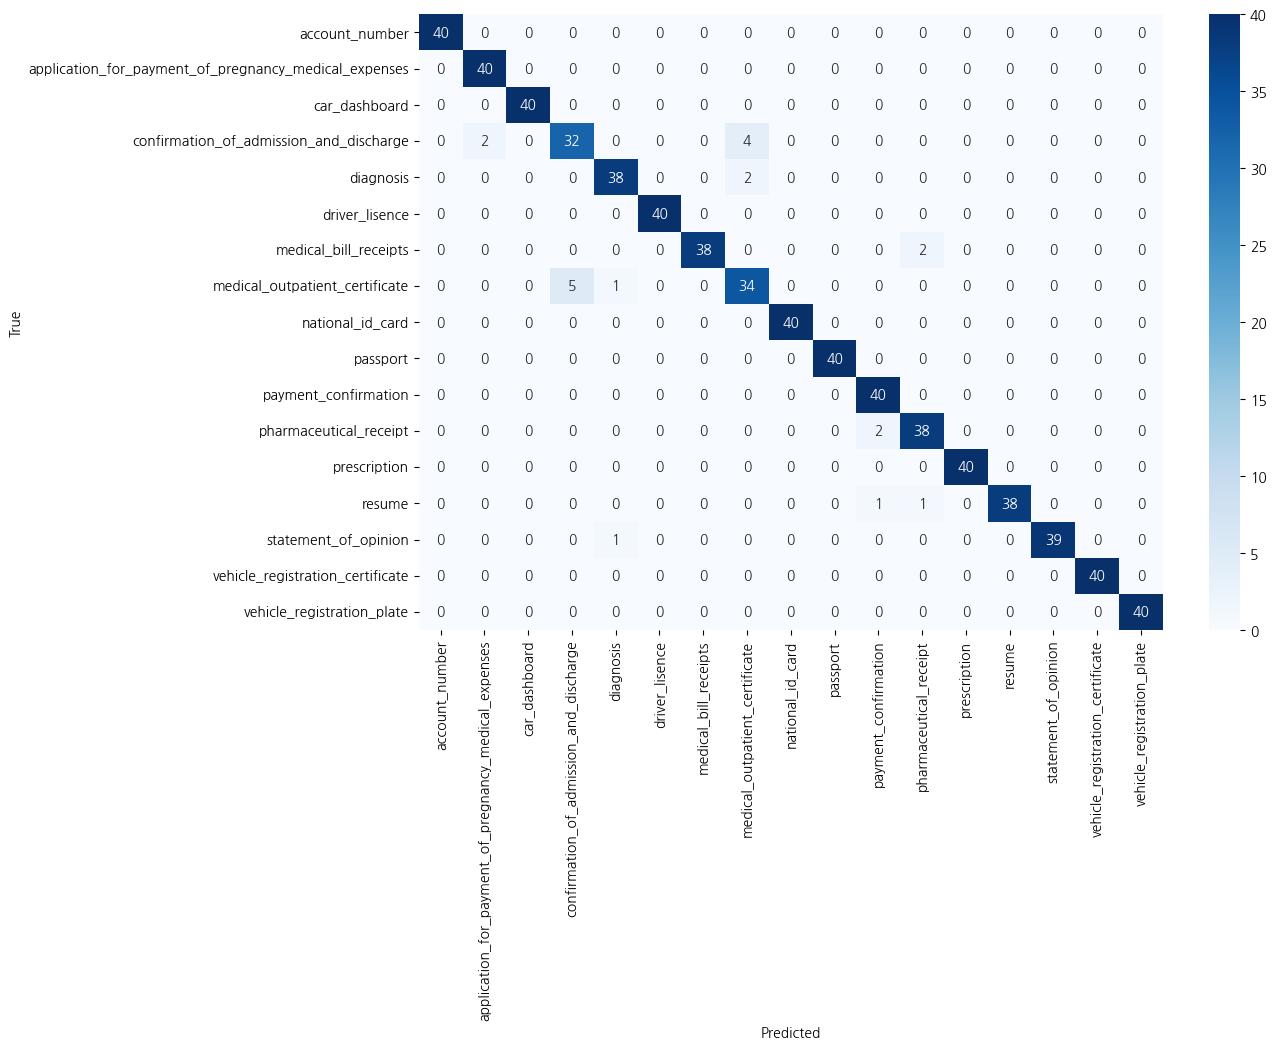

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()